### **Step 1: Data Preparation and Clustering** ###

First, we need to group patients into meaningful subgroups based on similar characteristics (x1,x2,x3,age).

1.1. Standardization:
- Since the variables have different scales, StandardScaler is used to normalize x1, x2, x3, and age.

1.2. Find Optimal Clusters:
- The optimal number of clusters is determined using the silhouette score, which measures how well the points fit within their clusters.
- KMedoids clustering is tested for k = 2 to k = 5, and the best number of clusters is chosen based on the highest silhouette score.

1.3. Clustering Implementation:
- The best k is selected, and the dataset is assigned corresponding cluster labels.

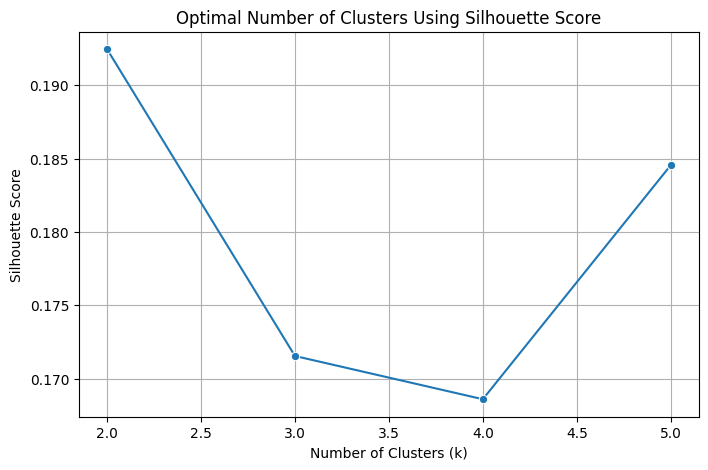

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the features
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[["x1", "x2", "x3", "age"]])

# Find the optimal number of clusters
silhouette_scores = {}
for k in range(2, 6):
    kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam').fit(X_cluster)
    score = silhouette_score(X_cluster, kmedoids.labels_)
    silhouette_scores[k] = score

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(silhouette_scores.keys()), y=list(silhouette_scores.values()), marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters Using Silhouette Score")
plt.grid(True)
plt.show()

### **Step 2: Inverse Probability of Censoring Weights (IPCW)** ###

Next, we'll need to adjust for censoring by estimating the probability that an observation remains uncensored.

2.1. Logistic Regression Model:
- For each cluster, a logistic regression model predicts the probability of censoring (censored variable).

2.2. Weight Calculation:
- The inverse probability of censoring weight (IPCW) is computed as 1 / predicted probability from the logistic model.

2.3. Handling the Error (Singular Matrix Issue):
- The error you encountered (LinAlgError: Singular matrix) suggests that some covariates are highly correlated or constant within a cluster.
- A potential fix is to drop highly correlated features or use regularization (penalized logistic regression) instead of standard logistic regression.



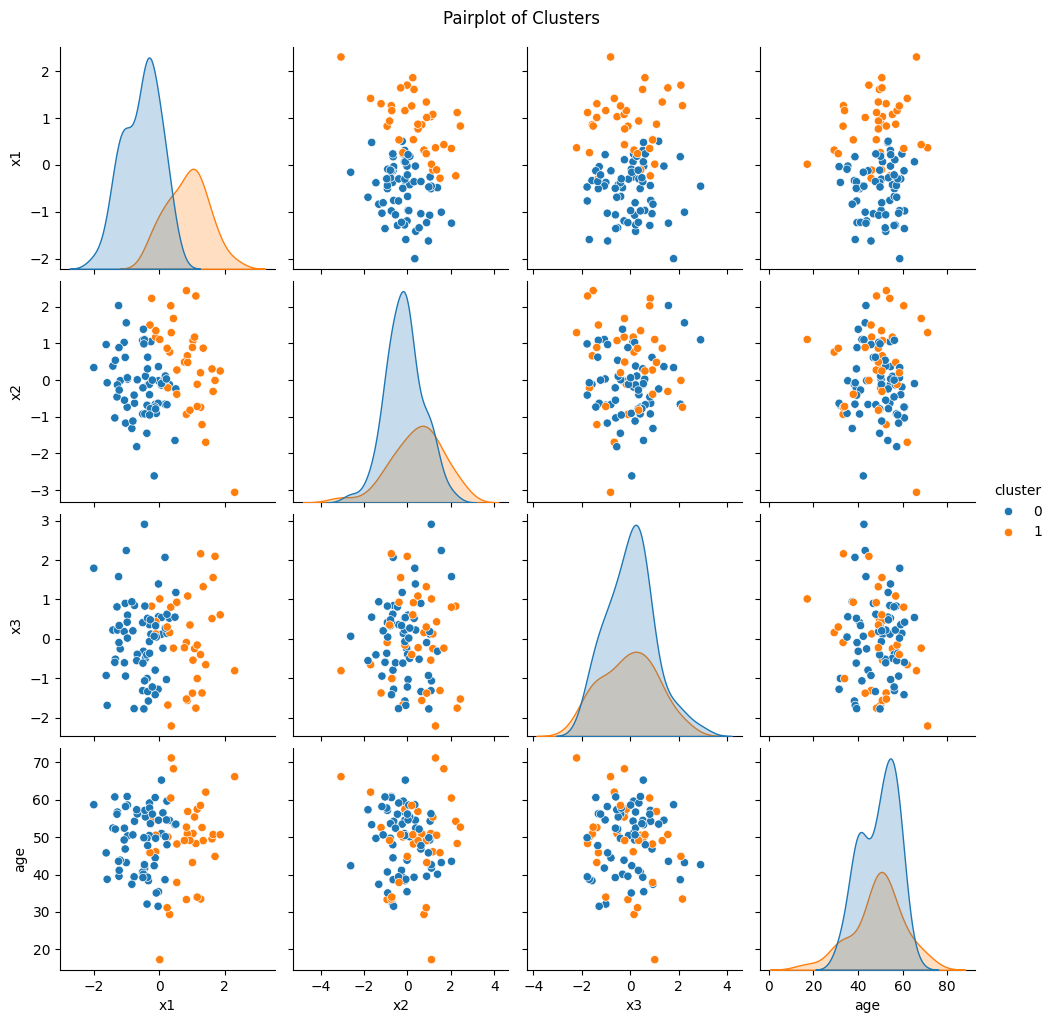

In [11]:
import seaborn as sns
import pandas as pd

# Apply clustering with the best k
best_k = max(silhouette_scores, key=silhouette_scores.get)
kmedoids = KMedoids(n_clusters=best_k, random_state=42, method='pam').fit(X_cluster)
df["cluster"] = kmedoids.labels_

# Pairplot of clusters
sns.pairplot(df, hue="cluster", vars=["x1", "x2", "x3", "age"], palette="tab10")
plt.suptitle("Pairplot of Clusters", y=1.02)
plt.show()


### **Step 3: Inverse Probability of Treatment Weights (IPTW)** ###

Then, we adjust for treatment assignment to estimate its effect unbiasedly.

3.1. Logistic Regression Model:
- Another logistic regression is trained to predict the probability of receiving treatment based on age, x1, and x3.

3.2. Weight Calculation:
- The inverse probability of treatment weight (IPTW) is computed as 1 / predicted probability.

3.3. Final Weights:
- The final stabilized weight is calculated by multiplying IPCW and IPTW.


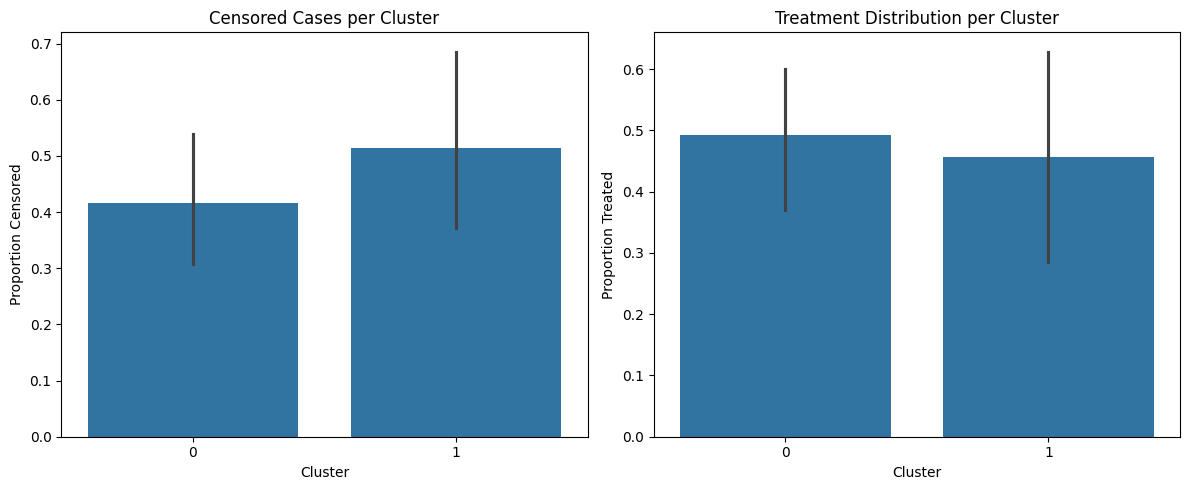

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Censored distribution
plt.subplot(1, 2, 1)
sns.barplot(x=df["cluster"], y=df["censored"])
plt.title("Censored Cases per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion Censored")

# Treatment distribution
plt.subplot(1, 2, 2)
sns.barplot(x=df["cluster"], y=df["treatment"])
plt.title("Treatment Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion Treated")

plt.tight_layout()
plt.show()


### **Step 4: Survival Analysis Using Kaplan-Meier Curves** ###

Lastly, we compare the survival probabilities across different clusters over time.

4.1. Kaplan-Meier Estimator:
- The Kaplan-Meier survival function estimates the probability of survival at each time point.
- Separate survival curves are computed for treated and untreated groups within each cluster.

4.2. Survival Difference Computation:
- The survival probability difference is calculated between treated and untreated groups.
- A confidence interval (CI) is added using standard error.

4.3. Visualization:
- The survival difference over time is plotted for each cluster.


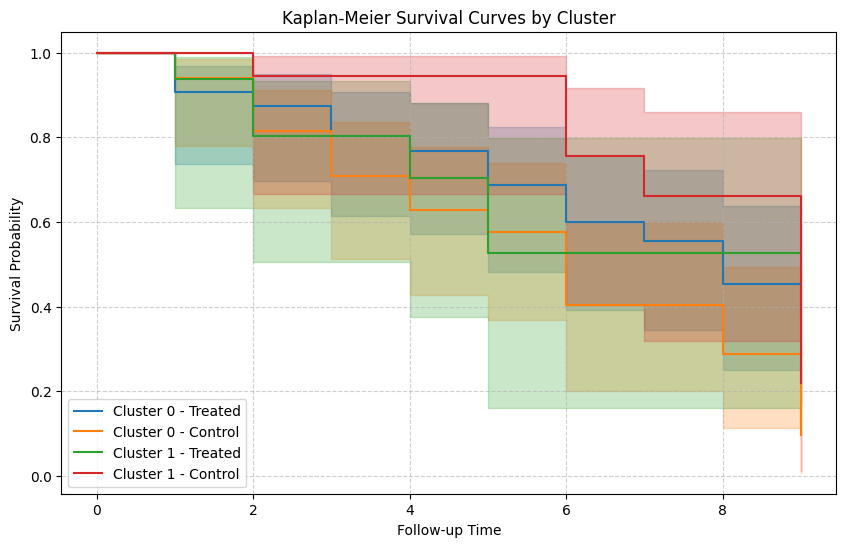

In [13]:
from lifelines import KaplanMeierFitter

time_points = np.arange(0, 11)

plt.figure(figsize=(10, 6))

for cluster in df["cluster"].unique():
    kmf_treatment = KaplanMeierFitter()
    kmf_control = KaplanMeierFitter()

    cluster_df = df[df["cluster"] == cluster]

    kmf_treatment.fit(cluster_df[cluster_df["treatment"] == 1]["period"],
                      event_observed=cluster_df[cluster_df["treatment"] == 1]["outcome"])

    kmf_control.fit(cluster_df[cluster_df["treatment"] == 0]["period"],
                    event_observed=cluster_df[cluster_df["treatment"] == 0]["outcome"])

    kmf_treatment.plot_survival_function(label=f"Cluster {cluster} - Treated")
    kmf_control.plot_survival_function(label=f"Cluster {cluster} - Control")

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Optimal number of clusters: 2
cluster
0    65
1    35
Name: count, dtype: int64


c:\Users\martb\AppData\Local\Programs\Python\Python313\Lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
c:\Users\martb\AppData\Local\Programs\Python\Python313\Lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. Se

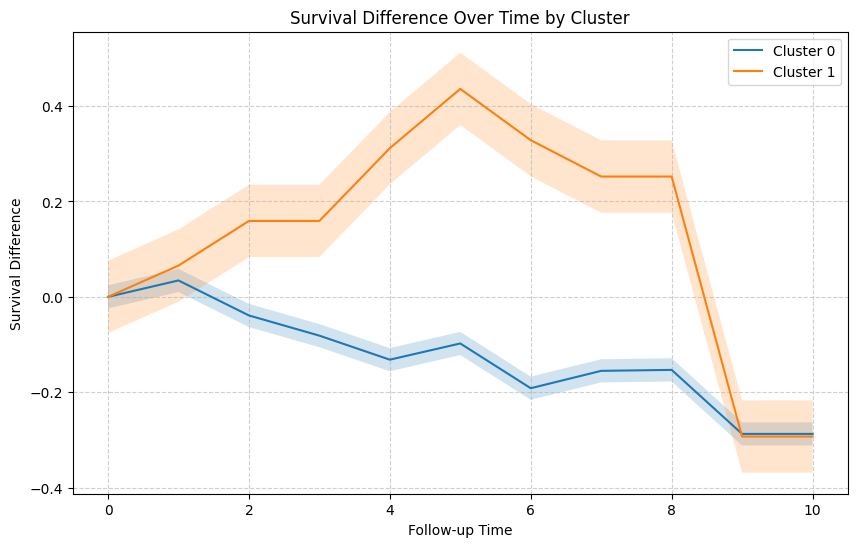

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from lifelines import KaplanMeierFitter
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score

# Load dataset
df = pd.read_csv("data_censored2.csv")

# Define key columns
id_col = "id"
period_col = "period"
treatment_col = "treatment"
outcome_col = "outcome"
eligible_col = "eligible"
censored_col = "censored"

# Define covariates
covariates = ["x1", "x2", "x3", "age"]

### Step 1: Clustering Patients into Subgroups ###
# Standardize covariates for better clustering performance
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[covariates])

# Determine optimal number of clusters using silhouette score
best_k = None
best_score = -1
for k in range(2, 6):  # Trying 2 to 5 clusters
    kmedoids = KMedoids(n_clusters=k, random_state=42, method='pam').fit(X_cluster)
    score = silhouette_score(X_cluster, kmedoids.labels_)
    if score > best_score:
        best_score = score
        best_k = k

# Apply clustering with best K
kmedoids = KMedoids(n_clusters=best_k, random_state=42, method='pam').fit(X_cluster)
df["cluster"] = kmedoids.labels_  # Assign cluster labels

print(f"Optimal number of clusters: {best_k}")
print(df["cluster"].value_counts())

### Step 2: Compute Inverse Probability of Censoring Weights (IPCW) per Cluster ###
df["censor_weight"] = np.nan

for cluster in df["cluster"].unique():
    cluster_df = df[df["cluster"] == cluster]
    X_censor = cluster_df[["x2", "x1"]]
    y_censor = cluster_df[censored_col]
    
    # Ensure X_censor has no constant columns
    if X_censor.nunique().min() > 1:
        X_censor = sm.add_constant(X_censor)
        
        # Use logistic regression with L2 regularization to avoid singular matrix
        censor_model = LogisticRegression(penalty="l2", solver="liblinear")
        censor_model.fit(X_censor, y_censor)
        
        df.loc[df["cluster"] == cluster, "censor_weight"] = 1 / censor_model.predict_proba(X_censor)[:, 1]
    else:
        print(f"Skipping cluster {cluster} due to constant predictors.")

### Step 3: Compute Inverse Probability of Treatment Weights (IPTW) per Cluster ###
df["switch_weight"] = np.nan

for cluster in df["cluster"].unique():
    cluster_df = df[df["cluster"] == cluster]
    X_switch = cluster_df[["age", "x1", "x3"]]
    y_switch = cluster_df[treatment_col]
    
    if X_switch.nunique().min() > 1:
        X_switch = sm.add_constant(X_switch)
        
        switch_model = LogisticRegression(penalty="l2", solver="liblinear")
        switch_model.fit(X_switch, y_switch)
        
        df.loc[df["cluster"] == cluster, "switch_weight"] = 1 / switch_model.predict_proba(X_switch)[:, 1]
    else:
        print(f"Skipping cluster {cluster} due to constant predictors.")

# Compute final stabilized weight
df["weight"] = df["censor_weight"] * df["switch_weight"]

### Step 4: Kaplan-Meier Survival Curves for Each Cluster ###
time_points = np.arange(0, 11)

plt.figure(figsize=(10, 6))

for cluster in df["cluster"].unique():
    kmf_treatment = KaplanMeierFitter()
    kmf_control = KaplanMeierFitter()
    
    cluster_df = df[df["cluster"] == cluster]
    
    kmf_treatment.fit(cluster_df[cluster_df[treatment_col] == 1][period_col],
                      event_observed=cluster_df[cluster_df[treatment_col] == 1][outcome_col],
                      weights=cluster_df[cluster_df[treatment_col] == 1]["weight"])
    
    kmf_control.fit(cluster_df[cluster_df[treatment_col] == 0][period_col],
                    event_observed=cluster_df[cluster_df[treatment_col] == 0][outcome_col],
                    weights=cluster_df[cluster_df[treatment_col] == 0]["weight"])
    
    survival_treatment = kmf_treatment.survival_function_at_times(time_points).values
    survival_control = kmf_control.survival_function_at_times(time_points).values
    survival_diff = survival_control - survival_treatment
    
    ci_width = 1.96 * np.std(survival_diff) / np.sqrt(len(cluster_df))
    ci_lower = survival_diff - ci_width
    ci_upper = survival_diff + ci_width
    
    plt.plot(time_points, survival_diff, label=f"Cluster {cluster}", linestyle="solid")
    plt.fill_between(time_points, ci_lower, ci_upper, alpha=0.2)

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Difference Over Time by Cluster")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### **Insights** ###

- Cluster Selection:
    - The optimal number of clusters ensures that groups are well separated based on the silhouette score.

- Censoring and Treatment Imbalance:
    - If certain clusters have higher censoring rates, the IPCW adjustment is critical to avoid bias in survival analysis.
    - If treatment is unevenly distributed across clusters, it suggests that specific patient groups may have had different probabilities of receiving treatment.

- Survival Difference:
    - The survival difference graph shows how treatment influences survival across clusters.
    - A large difference suggests strong treatment effects, while small differences indicate minimal effect.